In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

,"LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)",Spread EU-US,Spread ASIA-US,Spread ASIA-EU
Date,,,,
2019-01-01,91358.0,4.05,5.18,1.12
2019-02-01,68722.0,3.31,3.82,0.51
2019-03-01,48350.0,2.39,2.44,0.05
2019-04-01,48500.0,2.36,2.48,0.13
2019-05-01,64600.0,1.77,2.44,0.67
...,...,...,...,...
2024-08-01,76800.0,10.10,11.12,1.02
2024-09-01,67000.0,9.35,10.69,1.34
2024-10-01,45313.0,10.18,10.54,0.36


mean_squared_error: {'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)': 2538756344.0139575, 'Spread EU-US': 18.3187518624176, 'Spread ASIA-US': 11.01267599486252, 'Spread ASIA-EU': 0.93545142112248}
Index(['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
       'Spread EU-US', 'Spread ASIA-US', 'Spread ASIA-EU'],
      dtype='object')


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


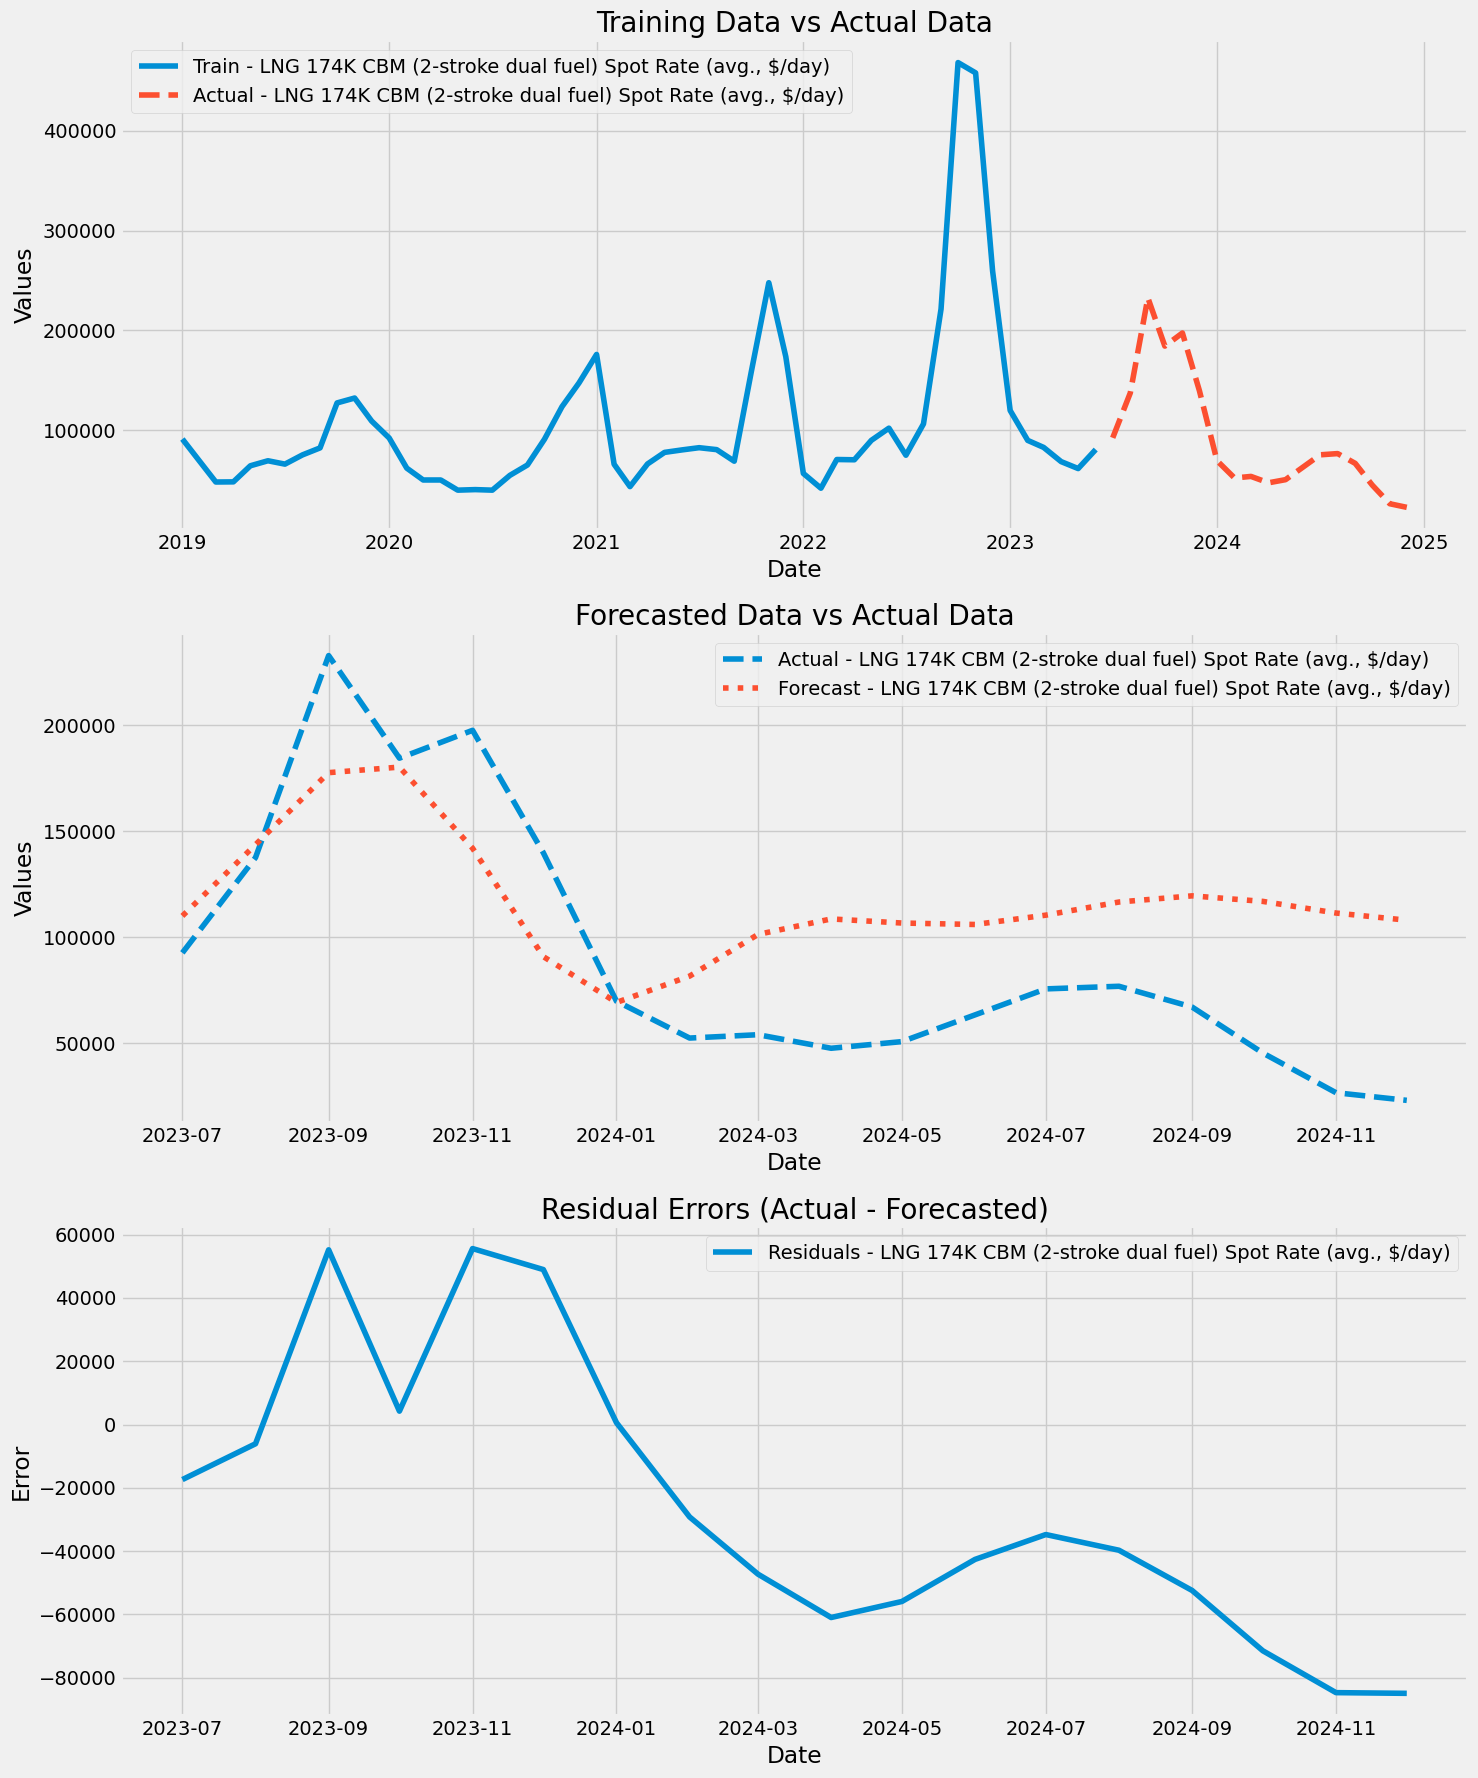

In [2]:
data = pd.read_csv("datatest2.csv")
#display(data)
data['Date'] = pd.to_datetime(data['Date'], format="%b.%y")
data.set_index('Date', inplace=True)
data.dropna(inplace=True)
data = data.apply(pd.to_numeric, errors='coerce')
#display(data)
data = data.drop(columns='LNG 145K CBM (Steam Turbine) Spot Rate (avg., $/day)')
#data.drop(data.columns[[3,4,5,5,6,7]], axis=1)
#data.drop(['Aprox.\nShip on order',
#            'Global price of Natural Gas, Asia (start month, MMBTU)',
#            'Global price of Natural Gas, EU (start month, MMBTU)',
#            'Global price of Natural Gas, US Henry Hub (start month, MMBTU)'], axis=1)

#Index(['LNG 145K CBM (Steam Turbine) Spot Rate\n(avg., $/day)', 
# LNG 174K CBM (2-stroke dual fuel) Spot Rate\n(avg., $/day)',
#'LNG Carrier Newbuilding Prices (end month, $m)',
#'LNG Orderbook (start month, CBM)', 'Aprox.\nShip on order',
#'Global price of Natural Gas, Asia (start month, MMBTU)',
#'Global price of Natural Gas, EU (start month, MMBTU)',
#'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
#'Spread\nEU-US', 'Spread\nASIA-US', 'Spread\nASIA-EU']

display(data)

train_size = int(len(data) * 0.75)
train, test = data[0:train_size], data[train_size:]

model = VAR(train)
model_fit = model.fit(maxlags=7, ic='aic')

lag_order = model_fit.k_ar
forecast = model_fit.forecast(train.values[-lag_order:], len(test))

forecast_df = pd.DataFrame(forecast, index=data.index[train_size:], columns=data.columns)
forecast_df = forecast_df.clip(lower=0)

mse_values = {col: mean_squared_error(test[col], forecast_df[col]) for col in data.columns}
print("mean_squared_error:", mse_values)


print(data.columns)
#plotcolumns = ['LNG 145K CBM (Steam Turbine) Spot Rate (avg., $/day)',
#               'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)']
plotcolumns = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)']
fig, axes = plt.subplots(3, 1, figsize=(15, 18))


axes[0].set_title("Training Data vs Actual Data")
for col in plotcolumns:
    axes[0].plot(train.index, train[col], label=f"Train - {col}")
    axes[0].plot(test.index, test[col], label=f"Actual - {col}", linestyle="dashed")
axes[0].legend()
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Values")
axes[0].grid(True)


axes[1].set_title("Forecasted Data vs Actual Data")
for col in plotcolumns:
    axes[1].plot(test.index, test[col], label=f"Actual - {col}", linestyle="dashed")
    axes[1].plot(forecast_df.index, forecast_df[col], label=f"Forecast - {col}", linestyle="dotted")
axes[1].legend()
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Values")
axes[1].grid(True)


axes[2].set_title("Residual Errors (Actual - Forecasted)")
for col in plotcolumns:
    residuals = test[col] - forecast_df[col]
    axes[2].plot(residuals.index, residuals, label=f"Residuals - {col}")
axes[2].legend()
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Error")
axes[2].grid(True)


plt.tight_layout()
plt.show()

mean_squared_error for 1 lags: {'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)': 3468616925.708936, 'Spread EU-US': 5.755963463065509, 'Spread ASIA-US': 4.240616297915558, 'Spread ASIA-EU': 0.7392343075091673}
mean_squared_error for 2 lags: {'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)': 2660154415.7753997, 'Spread EU-US': 4.795333139564124, 'Spread ASIA-US': 3.271543189736204, 'Spread ASIA-EU': 0.6070223904301083}
mean_squared_error for 3 lags: {'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)': 2620473036.755529, 'Spread EU-US': 19.529040667952618, 'Spread ASIA-US': 15.245962810740604, 'Spread ASIA-EU': 1.4771774370937643}
mean_squared_error for 4 lags: {'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)': 2620473036.755529, 'Spread EU-US': 19.529040667952618, 'Spread ASIA-US': 15.245962810740604, 'Spread ASIA-EU': 1.4771774370937643}
mean_squared_error for 5 lags: {'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)': 2620473036.755

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

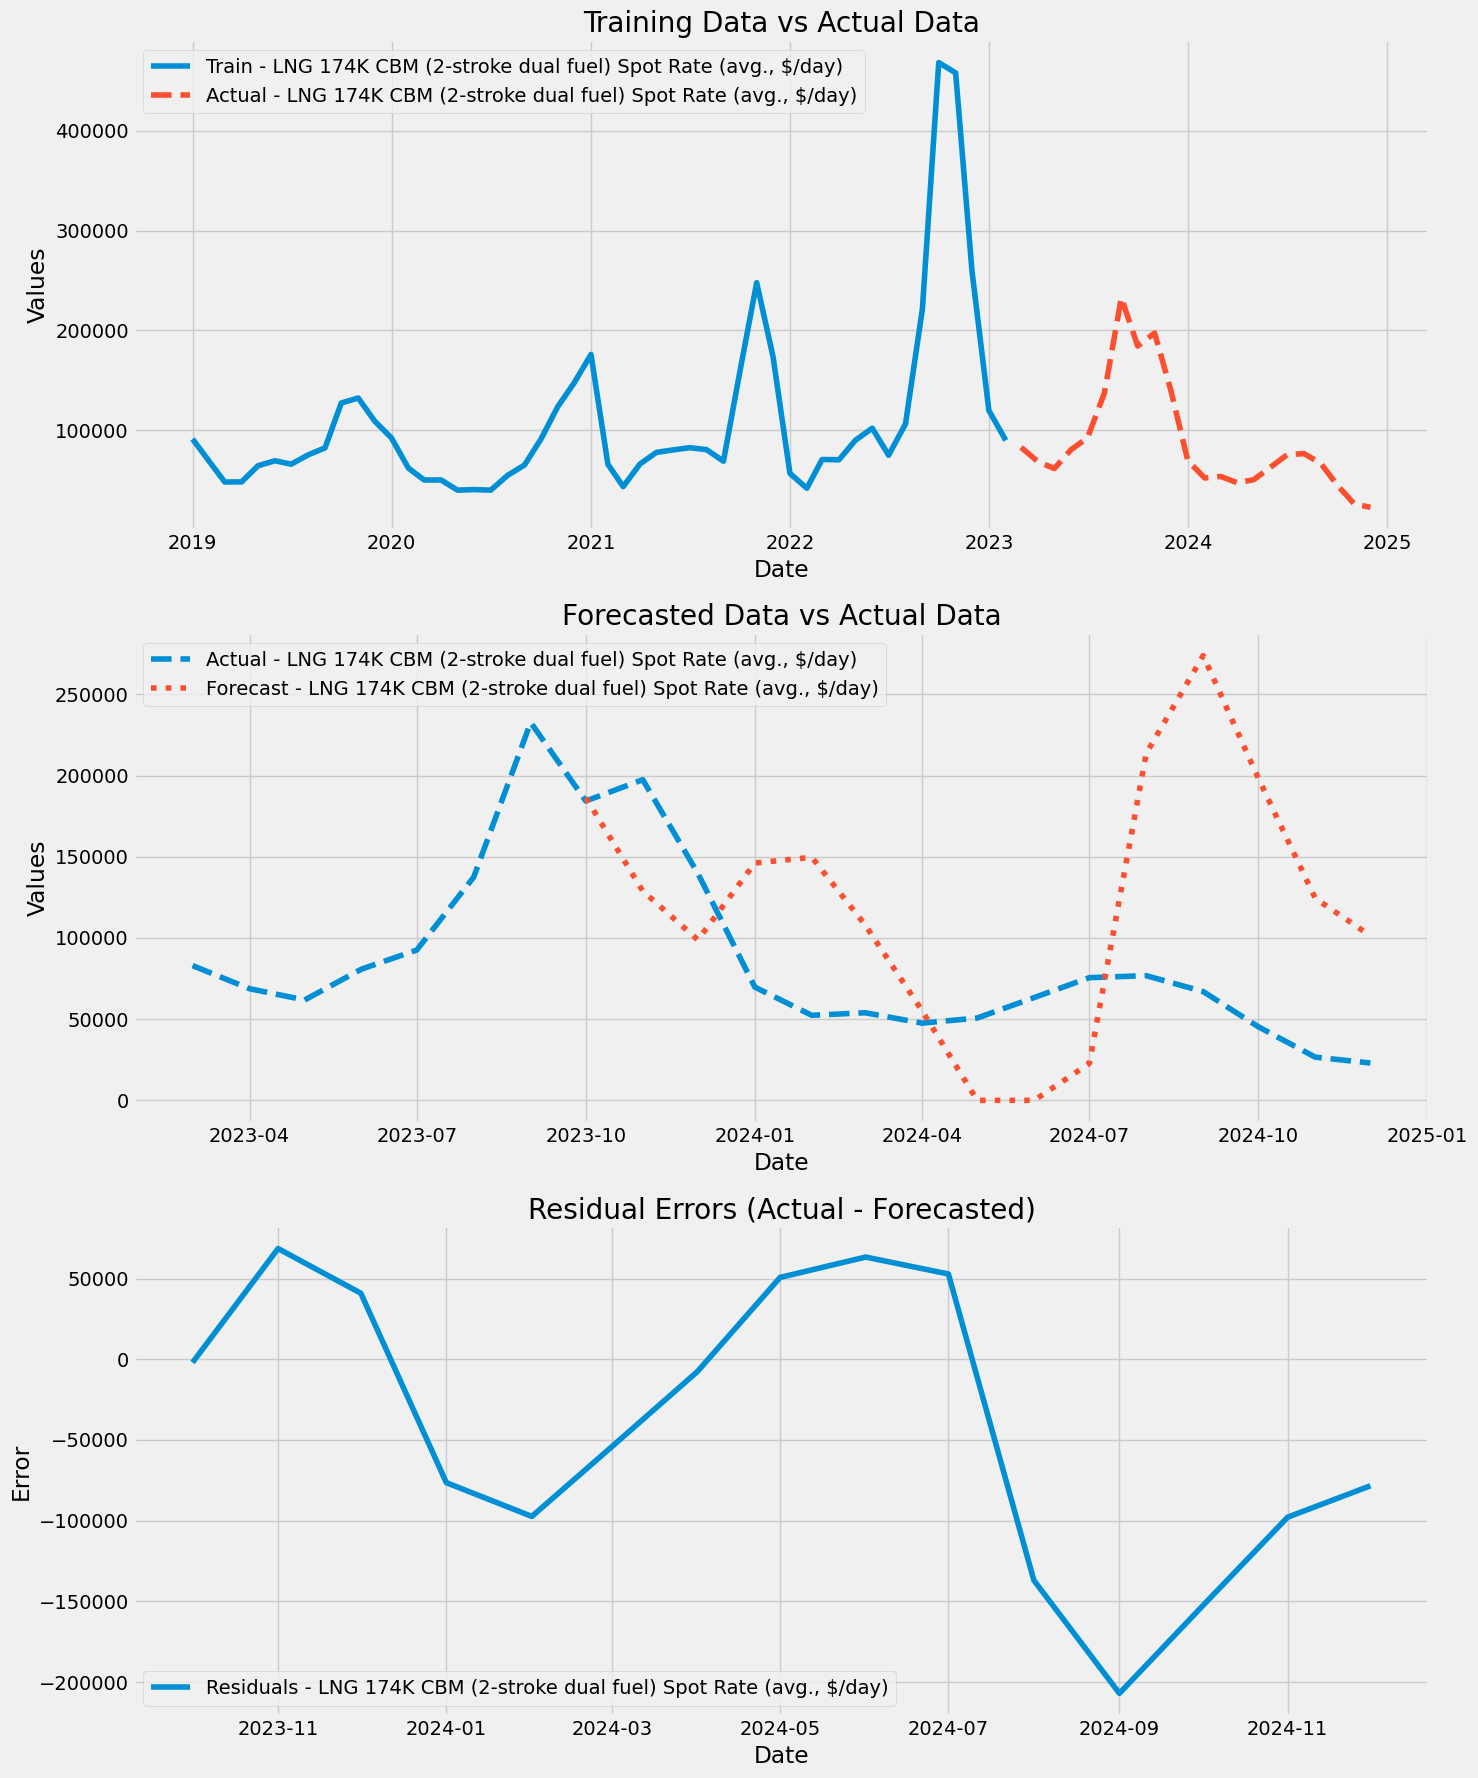

In [3]:
data = pd.read_csv("datatest2.csv")
#display(data)
data['Date'] = pd.to_datetime(data['Date'], format="%b.%y")
data.set_index('Date', inplace=True)
data.dropna(inplace=True)
data = data.apply(pd.to_numeric, errors='coerce')
#display(data)
data = data.drop(columns='LNG 145K CBM (Steam Turbine) Spot Rate (avg., $/day)')

for nooflags in range(1, 10):
    train_size = int(len(data) * 0.8)
    train, test = data[0:train_size], data[train_size:]

    model = VAR(train)
    model_fit = model.fit(maxlags=nooflags, ic='aic')

    lag_order = model_fit.k_ar
    forecast = model_fit.forecast(train.values[-lag_order:], len(test))

    forecast_df = pd.DataFrame(forecast, index=data.index[train_size:], columns=data.columns)
    forecast_df = forecast_df.clip(lower=0)

    mse_values = {col: mean_squared_error(test[col], forecast_df[col]) for col in data.columns}
    print(f"mean_squared_error for {nooflags} lags:", mse_values)


    if mse_values['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)'] < 0.1:
        break
train_size = int(len(data) * 0.7)
train, test = data[0:train_size], data[train_size:]



#plotcolumns = ['LNG 145K CBM (Steam Turbine) Spot Rate (avg., $/day)',
#               'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)']
plotcolumns = ['LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)']
fig, axes = plt.subplots(3, 1, figsize=(15, 18))


axes[0].set_title("Training Data vs Actual Data")
for col in plotcolumns:
    axes[0].plot(train.index, train[col], label=f"Train - {col}")
    axes[0].plot(test.index, test[col], label=f"Actual - {col}", linestyle="dashed")
axes[0].legend()
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Values")
axes[0].grid(True)


axes[1].set_title("Forecasted Data vs Actual Data")
for col in plotcolumns:
    axes[1].plot(test.index, test[col], label=f"Actual - {col}", linestyle="dashed")
    axes[1].plot(forecast_df.index, forecast_df[col], label=f"Forecast - {col}", linestyle="dotted")
axes[1].legend()
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Values")
axes[1].grid(True)


axes[2].set_title("Residual Errors (Actual - Forecasted)")
for col in plotcolumns:
    residuals = test[col] - forecast_df[col]
    axes[2].plot(residuals.index, residuals, label=f"Residuals - {col}")
axes[2].legend()
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Error")
axes[2].grid(True)


plt.tight_layout()
plt.show()